# Importing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import datetime

In [2]:
# Reading data into dataframes

games = pd.read_csv('games.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
turns = pd.read_csv('turns.csv')

In [3]:
# Visual data structure exploration

display(sample_submission.head(2))
print(sample_submission.shape)
display(train.head(4))
print(train.shape)
display(test.head(4))
print(test.shape)

,game_id,rating
0,2,1790.322674
1,7,1790.322674


(22363, 2)


,game_id,nickname,score,rating
0,1,BetterBot,335,1637
1,1,stevy,429,1500
2,3,davidavid,440,1811
3,3,BetterBot,318,2071


(100820, 4)


,game_id,nickname,score,rating
0,2,Super,488,NaN
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0
3,7,Priya1,379,NaN


(44726, 4)


# Data preparation

In [4]:
display(games.head(2))
print(games.shape)

,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418


(72773, 12)


## Games

In [5]:
def preparation_games(table):
    
    '''
    Feature engineers dataframe for machine learning and analysis
    Converting all time values to minutes
    '''

    fe_games = pd.DataFrame() # empty dataframe for feature engineering

    # Copying numerical data
    
    fe_games['game_id'] = table['game_id']
    fe_games['winner'] = table['winner']
    fe_games['init_time_secs'] = table['initial_time_seconds']
    fe_games['incr_seconds'] = table['increment_seconds']
    fe_games['max_otime_mins'] = table['max_overtime_minutes']
    fe_games['game_dur_secs'] = table['game_duration_seconds'].astype('int')
    
    # Modyfying datetime data
    
    fe_games['created_at'] = pd.to_datetime(table['created_at'])
    fe_games['weekday'] = fe_games['created_at'].dt.dayofweek + 1
    fe_games['time'] = fe_games['created_at'].dt.hour
    fe_games = fe_games.drop('created_at', axis=1)
    
    # Converting categorical data to integers

    time_control = {i: j for j, i in enumerate(table.time_control_name.unique())}
    fe_games['time_control'] = table['time_control_name'].replace(time_control)
    
    game_end_reason = {i: j for j, i in enumerate(table.game_end_reason.unique())}
    fe_games['game_end_reason'] = table['game_end_reason'].replace(game_end_reason)

    lexicon = {i: j for j, i in enumerate(table.lexicon.unique())}
    fe_games['lexicon'] = table['lexicon'].replace(lexicon)

    rating_mode = {i: j for j, i in enumerate(table.rating_mode.unique())}
    fe_games['rating_mode'] = table['rating_mode'].replace(rating_mode)

    return fe_games

In [6]:
prep_games = preparation_games(games)

In [7]:
prep_games

,game_id,winner,init_time_secs,incr_seconds,max_otime_mins,game_dur_secs,weekday,time,time_control,game_end_reason,lexicon,rating_mode
0,1,1,1200,0,1,674,5,3,0,0,0,0
1,2,1,3600,0,1,364,3,19,0,0,1,1
2,3,1,900,0,5,492,7,8,0,0,1,1
3,4,0,3600,0,1,350,1,2,0,1,1,0
4,5,0,1200,0,1,642,2,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
72768,72769,0,180,0,1,218,3,13,2,0,1,1
72769,72770,0,3600,0,1,3662,7,0,0,2,1,1
72770,72771,0,900,0,10,236,1,3,0,0,2,0
72771,72772,0,900,0,1,681,3,15,0,0,0,1


## Turns

### Defining dictionary with points per letter

In [8]:
letter_points = {'a':1, 'b':3, 'c':3, 'd':2, 'e':1, 'f':4, 'g':2, 'h':4, 'i':1, \
                 'j':8, 'k':5, 'l':1, 'm':3, 'n':1, 'o':1, 'p':3, 'q':10, 'r':1, \
                 's':1, 't':1, 'u':1, 'v':8, 'w':4, 'x':8, 'y':4, 'z':10, '?':0}

### Turn types

In [9]:
# Correcting mistaken plays

turns_to_modify = list(turns[(turns.move == '--') & (turns.turn_type == 'Exchange')].index-1)

for i in turns_to_modify:
    turns.iat[i, 8] = 'Mistake'
    turns.iat[i, 5] = ''
    turns.iat[i, 6] = 0

In [10]:
# Deleting mistaken plays counted as exchange

print(len(turns))

turns_to_delete = list(turns[(turns.move == '--') & (turns.turn_type == 'Exchange')].index)

turns = turns.drop(turns_to_delete)

print(len(turns))

2005498
1991196


### Creating copy of turns for numeric data only

In [11]:
turns_to_count = turns.copy()
turns_to_count[turns_to_count.game_id == 5980]

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
164583,5980,1,Inandoutworker,AAENOTT,NaN,-,0,0,Pass
164584,5980,2,BetterBot,CEGILSU,8D,GUILE,16,16,Play
164585,5980,3,Inandoutworker,AAENOTT,NaN,-,0,0,Pass
164586,5980,4,BetterBot,CMORSSV,F7,V.M,8,24,Play
164587,5980,5,Inandoutworker,AAENOTT,NaN,-,0,0,Pass
164588,5980,6,BetterBot,BCORRSS,7H,BROS,11,35,Play
164589,5980,7,Inandoutworker,AAENOTT,NaN,-,0,0,Pass
164590,5980,8,BetterBot,CEHQRRS,NaN,-QR,0,35,Exchange
164591,5980,9,Inandoutworker,AAENOTT,NaN,-,0,0,Pass
164592,5980,10,BetterBot,ACEGHRS,6J,HAG,30,65,Play


In [12]:
# Correcting NaN values in turn_type

turns_to_count = turns_to_count.reset_index(drop=True)
types_to_correct = list(turns_to_count[turns_to_count.turn_type.isnull()].index)

for i in types_to_correct:
    turns_to_count.iat[i, 8] = 'Play'
    
for i in types_to_correct:
    
    second = turns_to_count.iat[i,3]
    second_list = list(second.strip())
    j = i-2
    first = turns_to_count.iat[j,3]
    
    if isinstance(first, str):
        first_list = list(first.strip())
    else:
        first_list = list(second.strip())
    
    for e in second_list:
        try:
            first_list.remove(e)
        except:
            pass
    
    turns_to_count.iat[i, 5] = ''.join(first_list)

In [13]:
# Correcting NaN values in move

moves_to_correct = list(turns_to_count[turns_to_count.move.isnull()].index)

for i in moves_to_correct:
    
    second = turns_to_count.iat[i,3]
    second_list = list(second.strip())
    j = i-2
    first = turns_to_count.iat[j,3]
    
    if isinstance(first, str):
        first_list = list(first.strip())
    else:
        first_list = list(second.strip())
    
    for e in second_list:
        try:
            first_list.remove(e)
        except:
            pass
    
    turns_to_count.iat[i, 5] = ''.join(first_list)

In [14]:
# Correcting move values in turn_type=Pass

passes_to_correct = list(turns_to_count[turns_to_count.turn_type == 'Pass'].index)

for i in passes_to_correct:
    turns_to_count.iat[i, 5] = ''

In [15]:
# Dropping all but 'Play' turn_type

turns_to_count = turns_to_count[turns_to_count.turn_type.isin(['Play', 'Pass'])]

### Feature engineering turns_to_count table

In [16]:
def get_max_score(word):
    
    '''
    Gets maximum possible score from the rack letters
    '''
    
    counter = 0

    for letter in word.lower():
        counter += letter_points[letter]
    
    return counter

In [17]:
def fe_turns_to_count(table):
    
    '''
    Feature engineers dataframe for machine learning and analysis
    '''
    
    fe_turns_to_count = pd.DataFrame() # empty dataframe for feature engineering
    
    # Copying values
    
    fe_turns_to_count['game_id'] = table['game_id']
    fe_turns_to_count['turn_number'] = table['turn_number']
    fe_turns_to_count['nickname'] = table['nickname']
    fe_turns_to_count['points'] = table['points']
    fe_turns_to_count['turn_type'] = table['turn_type']
    
    # Move lenght
    fe_turns_to_count['move_len'] = table['move'].str.len()
    # Fillilng NaN
    fe_turns_to_count['move_len'] = fe_turns_to_count['move_len'].fillna(0).astype('int')
    
    # Calculating max points from rack
    fe_turns_to_count['rack'] = table['rack'].fillna('') # filling missing rack values from original with whitespace
    fe_turns_to_count['max_points'] = fe_turns_to_count.apply(lambda x: get_max_score(x.rack), axis=1) # calculating maximum points from rack
    fe_turns_to_count = fe_turns_to_count.drop('rack', axis=1)
    
    # Calculating maximum and average points per letter   
    fe_turns_to_count['points_per_letter_max'] = fe_turns_to_count['points'] / fe_turns_to_count['move_len']
    fe_turns_to_count['points_per_letter_max'] = fe_turns_to_count['points_per_letter_max'].replace(np.inf, 1)
    fe_turns_to_count['points_per_letter_avg'] = fe_turns_to_count['points'] / fe_turns_to_count['move_len']
    fe_turns_to_count['points_per_letter_avg'] = fe_turns_to_count['points_per_letter_avg'].replace(np.inf, 1)
    
    # Number of words on lines 1 and 15 and rows A and O (extremes)
    fe_turns_to_count['extremes'] = table['location'].str.contains(r'[A|O|a|o|1|15]').replace([True,False],[1,0])

    return fe_turns_to_count

In [18]:
fe_turns_to_count = fe_turns_to_count(turns_to_count)

In [19]:
fe_turns_to_count.sample(2)

,game_id,turn_number,nickname,points,turn_type,move_len,max_points,points_per_letter_max,points_per_letter_avg,extremes
1541808,56378,6,hasali.R,23,Play,3,10,7.666667,7.666667,0.0
1476773,53997,21,HastyBot,65,Play,7,8,9.285714,9.285714,1.0


### Feature engineering turns table

In [20]:
# Feature engineering TURNS table

def feature_engineering_turns(table):
    
    '''
    Feature engineers dataframe for machine learning and analysis
    '''
    
    fe_turns = pd.DataFrame() # empty dataframe for feature engineering
    fe_turns['game_id'] = table['game_id'] # copying game_id
    fe_turns['turn_number'] = table['turn_number'] # copying turn_number
    fe_turns['nickname'] = table['nickname'] # copying nickname
    fe_turns['turn_type'] = table['turn_type'] # copying nickname

    return fe_turns

In [21]:
fe_turns = feature_engineering_turns(turns)

In [22]:
# Splitting move_len column

fe_turns_move_len = pd.get_dummies(fe_turns_to_count.move_len, prefix='move_len')

fe_turns_to_count = fe_turns_to_count.merge(fe_turns_move_len, left_index=True, right_index=True)

In [23]:
# Splitting turn_type column

fe_turns_turn_type = pd.get_dummies(fe_turns.turn_type, prefix='turn_type')

fe_turns = fe_turns.merge(fe_turns_turn_type, left_index=True, right_index=True)

### Defining bots

In [24]:
bots = ['BetterBot', 'STEEBot', 'HastyBot']

### Converting turns to games

In [25]:
from functools import reduce

def turns_to_games(table1, table2):
    
    '''
    Converts turns table into games table
    '''
    
    # Empty dataframe to populate
    fe_turns_to_games = pd.DataFrame()
    
    # Average move lenght
    move_len_avg = table2.groupby(by=['game_id','nickname'], as_index=False)[['move_len']].mean()
    move_len_avg.columns = ['game_id', 'nickname', 'move_len_avg']
    
    # Median move lenght
    move_len_median = table2.groupby(by=['game_id','nickname'], as_index=False)[['move_len']].median()
    move_len_median.columns = ['game_id', 'nickname', 'move_len_med']
    
    # Number of turns in a game
    game_turns = table2.groupby(by=['game_id','nickname'], as_index=False)[['turn_number']].max()
    game_turns.columns = ['game_id', 'nickname', 'game_turns']

    # Number of turns in a game
    extreme_plays = table2.groupby(by=['game_id','nickname'], as_index=False)[['extremes']].sum()
    extreme_plays.columns = ['game_id', 'nickname', 'extreme_plays']

    # Maximum points per letter
    ppl_max = table2.groupby(by=['game_id','nickname'], as_index=False)[['points_per_letter_max']].max()
    ppl_max.columns = ['game_id', 'nickname', 'ppl_max']

    # Average points per letter
    ppl_avg = table2.groupby(by=['game_id','nickname'], as_index=False)[['points_per_letter_max']].mean()
    ppl_avg.columns = ['game_id', 'nickname', 'ppl_avg']
    
    # Summing turn types
    turn_type = table1.groupby(by=['game_id','nickname'], as_index=False)[fe_turns_turn_type.columns].sum()

    # Summing move lenghts
    move_len = table2.groupby(by=['game_id','nickname'], as_index=False)[fe_turns_move_len.columns].sum()


    # Merging all data
    
    data_frames = [move_len_avg, move_len_median, game_turns, extreme_plays, ppl_max, ppl_avg, turn_type, move_len]
    df_merged = reduce(lambda left, right: pd.merge(left,right, on=['game_id', 'nickname'], how='left'), data_frames)
    
    
    df_merged['opponent'] = df_merged.groupby('game_id')['nickname'].apply(lambda g: g[::-1]).reset_index(drop=True)
    
    df_merged['bot_type'] = df_merged['opponent'].replace({np.nan:0,'BetterBot':1, 'STEEBot':2, 'HastyBot':3})
    
    return df_merged
    

In [26]:
fe_turns_to_games = turns_to_games(fe_turns, fe_turns_to_count)
display(fe_turns_to_games.sample(2))

,game_id,nickname,move_len_avg,move_len_med,game_turns,extreme_plays,ppl_max,ppl_avg,turn_type_Challenge,turn_type_End,...,move_len_8,move_len_9,move_len_10,move_len_11,move_len_12,move_len_13,move_len_14,move_len_15,opponent,bot_type
48309,24155,STEEBot,4.538462,4.0,26,4.0,15.333333,7.551282,0,1,...,1,0,0,0,0,0,0,0,Anita,Anita
140810,70406,Kovert,4.846154,5.0,25,6.0,9.142857,5.672711,0,1,...,0,0,0,0,0,0,0,0,BetterBot,1


## Expanding data with opponent data

In [27]:
fe_turns_to_games

,game_id,nickname,move_len_avg,move_len_med,game_turns,extreme_plays,ppl_max,ppl_avg,turn_type_Challenge,turn_type_End,...,move_len_8,move_len_9,move_len_10,move_len_11,move_len_12,move_len_13,move_len_14,move_len_15,opponent,bot_type
0,1,BetterBot,4.615385,4.0,25,5.0,12.000000,6.042125,0,0,...,2,0,0,0,0,0,0,0,stevy,stevy
1,1,stevy,3.923077,3.0,26,8.0,17.500000,8.320696,0,1,...,0,0,0,0,0,0,0,0,BetterBot,1
2,2,BetterBot,5.250000,5.0,24,4.0,12.142857,5.967460,0,0,...,2,0,0,0,0,0,0,0,Super,Super
3,2,Super,4.250000,4.0,25,8.0,22.000000,10.151407,0,1,...,1,0,0,0,0,0,0,0,BetterBot,1
4,3,BetterBot,4.500000,4.0,25,6.0,11.500000,6.115873,0,0,...,1,0,0,0,0,0,0,0,davidavid,davidavid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145540,72771,HastyBot,3.857143,3.0,29,8.0,13.285714,6.457143,0,0,...,0,0,0,0,0,0,0,0,BB-8,BB-8
145541,72772,BetterBot,4.571429,4.5,28,8.0,18.000000,7.675340,0,0,...,2,0,0,0,0,0,0,0,Gtowngrad,Gtowngrad
145542,72772,Gtowngrad,3.533333,3.0,29,7.0,21.000000,7.585317,0,1,...,1,0,0,0,0,0,0,0,BetterBot,1
145543,72773,HastyBot,4.230769,4.0,25,7.0,9.750000,6.370513,0,1,...,0,0,0,0,0,0,0,0,adola,adola


In [28]:
def expand_games(table):
    
    '''
    Combines feature engineered turns table with games, train and test sets
    table1 - feature engineered turns
    table2 - games table
    '''
    
    fe_combined_full = table.merge(table, how='left', left_on=['game_id', 'nickname'], right_on=['game_id', 'opponent'],
                                   suffixes=[None, '_by_oponent'])
    
    fe_combined_full = fe_combined_full.drop(['opponent_by_oponent','bot_type_by_oponent', 'nickname_by_oponent'], axis=1)
    
    
    
    return fe_combined_full

In [29]:
fe_combined_full = expand_games(fe_turns_to_games)

## Combining train/test table with features engineered

In [30]:
def combined(table, games_table):
    
    '''
    Combines feature engineered turns table with games, train and test sets
    table1 - feature engineered turns
    table2 - games table
    '''
    
    train_n_test = pd.concat([train, test])
    
    fe_combined_all = train_n_test.merge(table, how='left', on=['game_id', 'nickname'])
    
    fe_combined_all = fe_combined_all.merge(games_table, how='left', on=['game_id'])
    
    
    return fe_combined_all, train_n_test

In [31]:
fe_combined_all, train_n_test = combined(fe_combined_full, prep_games)
fe_combined_all

,game_id,nickname,score,rating,move_len_avg,move_len_med,game_turns,extreme_plays,ppl_max,ppl_avg,...,init_time_secs,incr_seconds,max_otime_mins,game_dur_secs,weekday,time,time_control,game_end_reason,lexicon,rating_mode
0,1,BetterBot,335,1637.0,4.615385,4.0,25.0,5.0,12.000000,6.042125,...,1200,0,1,674,5,3,0,0,0,0
1,1,stevy,429,1500.0,3.923077,3.0,26.0,8.0,17.500000,8.320696,...,1200,0,1,674,5,3,0,0,0,0
2,3,davidavid,440,1811.0,4.153846,4.0,26.0,9.0,18.000000,8.212637,...,900,0,5,492,7,8,0,0,1,1
3,3,BetterBot,318,2071.0,4.500000,4.0,25.0,6.0,11.500000,6.115873,...,900,0,5,492,7,8,0,0,1,1
4,4,Inandoutworker,119,1473.0,2.666667,2.5,28.0,5.0,8.000000,3.381944,...,3600,0,1,350,1,2,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145541,72762,kyjo55555,367,NaN,3.538462,3.0,27.0,8.0,16.750000,8.064744,...,3600,0,1,386,3,11,0,0,0,0
145542,72768,HastyBot,524,2356.0,5.363636,6.0,21.0,9.0,26.000000,10.012662,...,3600,0,1,2155,6,7,0,0,1,1
145543,72768,Maximilian,357,NaN,4.818182,4.0,22.0,4.0,12.333333,6.354329,...,3600,0,1,2155,6,7,0,0,1,1
145544,72769,STEEBot,626,2110.0,4.307692,4.0,28.0,5.0,24.250000,10.332418,...,180,0,1,218,3,13,2,0,1,1


## Converting players to integers

In [32]:
players = set(train.nickname.unique()).union(set(test.nickname.unique())).union(set(fe_combined_all.nickname.unique())) \
    .union(set(fe_combined_all.opponent.unique()))

players_dict = {i: j for j, i in enumerate(players)}

In [33]:
bots_numbered = []

for bot in bots:
    bots_numbered.append(players_dict[bot])
    
bots_numbered

[1070, 162, 1276]

In [34]:
train['nickname'] = train['nickname'].replace(players_dict)
test['nickname'] = test['nickname'].replace(players_dict)
fe_combined_all['nickname'] = fe_combined_all['nickname'].replace(players_dict)
fe_combined_all['opponent'] = fe_combined_all['opponent'].replace(players_dict)

## Calculating time since previous game

In [35]:
games_sub = games[['game_id','created_at']]
fe_combined_dates = fe_combined_all.merge(games_sub, how='left', on='game_id')
fe_combined_dates = fe_combined_dates[['game_id','nickname','created_at']].sort_values(by='created_at').reset_index(drop=True)

fe_combined_dates.head(4)

,game_id,nickname,created_at
0,55419,162,2022-07-27 08:53:39
1,55419,59,2022-07-27 08:53:39
2,14373,162,2022-07-27 08:53:40
3,14373,1158,2022-07-27 08:53:40


In [36]:
fe_combined_dates_prev = fe_combined_dates.groupby(['nickname'])[['created_at']] \
    .apply(lambda x: x.shift(periods=1, axis=0)).fillna(method='bfill')

fe_combined_dates_prev.head(4)

,created_at
0,2022-07-27 08:53:39
1,2022-07-27 08:53:39
2,2022-07-27 08:53:39
3,2022-07-27 08:53:40


In [37]:
fe_combined_dates_all = fe_combined_dates.merge(fe_combined_dates_prev, how='left', left_index=True, right_index=True)

fe_combined_dates_all['time_since_last'] = pd.to_datetime(fe_combined_dates_all.created_at_x) - \
    pd.to_datetime(fe_combined_dates_all.created_at_y)
fe_combined_dates_all['minutes_since_last'] = round(fe_combined_dates_all['time_since_last'].dt.total_seconds() / 60, 2)
fe_combined_dates_all.head(4)

,game_id,nickname,created_at_x,created_at_y,time_since_last,minutes_since_last
0,55419,162,2022-07-27 08:53:39,2022-07-27 08:53:39,0 days 00:00:00,0.00
1,55419,59,2022-07-27 08:53:39,2022-07-27 08:53:39,0 days 00:00:00,0.00
2,14373,162,2022-07-27 08:53:40,2022-07-27 08:53:39,0 days 00:00:01,0.02
3,14373,1158,2022-07-27 08:53:40,2022-07-27 08:53:40,0 days 00:00:00,0.00


In [38]:
fe_combined_dates_all = fe_combined_dates_all[['game_id','nickname','minutes_since_last']]
fe_combined_dates_all

,game_id,nickname,minutes_since_last
0,55419,162,0.00
1,55419,59,0.00
2,14373,162,0.02
3,14373,1158,0.00
4,40657,1158,5.02
...,...,...,...
145541,68784,1276,2.07
145542,62014,1276,4.65
145543,62014,1079,6.72
145544,23626,1276,9.22


In [39]:
fe_combined_all = fe_combined_all.merge(fe_combined_dates_all, how='left', on=['game_id','nickname'])
fe_combined_all

,game_id,nickname,score,rating,move_len_avg,move_len_med,game_turns,extreme_plays,ppl_max,ppl_avg,...,incr_seconds,max_otime_mins,game_dur_secs,weekday,time,time_control,game_end_reason,lexicon,rating_mode,minutes_since_last
0,1,1070,335,1637.0,4.615385,4.0,25.0,5.0,12.000000,6.042125,...,0,1,674,5,3,0,0,0,0,4.53
1,1,1044,429,1500.0,3.923077,3.0,26.0,8.0,17.500000,8.320696,...,0,1,674,5,3,0,0,0,0,12.37
2,3,24,440,1811.0,4.153846,4.0,26.0,9.0,18.000000,8.212637,...,0,5,492,7,8,0,0,1,1,644.85
3,3,1070,318,2071.0,4.500000,4.0,25.0,6.0,11.500000,6.115873,...,0,5,492,7,8,0,0,1,1,3.68
4,4,389,119,1473.0,2.666667,2.5,28.0,5.0,8.000000,3.381944,...,0,1,350,1,2,0,1,1,0,224.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145541,72762,321,367,NaN,3.538462,3.0,27.0,8.0,16.750000,8.064744,...,0,1,386,3,11,0,0,0,0,2181.20
145542,72768,1276,524,2356.0,5.363636,6.0,21.0,9.0,26.000000,10.012662,...,0,1,2155,6,7,0,0,1,1,1.82
145543,72768,1071,357,NaN,4.818182,4.0,22.0,4.0,12.333333,6.354329,...,0,1,2155,6,7,0,0,1,1,1377.45
145544,72769,162,626,2110.0,4.307692,4.0,28.0,5.0,24.250000,10.332418,...,0,1,218,3,13,2,0,1,1,2.15


# Preparing data for ml

In [40]:
def merge_for_ml(labels_table, features_table):
    
    '''
    Merging features with labels to assure ml trains on correct indices
    '''
    
    full_train = labels_table.merge(features_table, on=['game_id','nickname', 'score', 'rating'], how='left')
    
    full_train['score_previous'] = full_train.groupby('nickname')['score'] \
        .apply(lambda x: x.shift(periods=1, axis=0)).fillna(method='bfill')

    full_train['score_previous_2'] = full_train.groupby('nickname')['score'] \
        .apply(lambda x: x.shift(periods=2, axis=0)).fillna(method='bfill')

    full_train['score_delta'] = full_train['score_previous'] - full_train['score_previous_2']
    
    # Extracting bots
    full_train_bots = full_train[full_train.nickname.isin(bots_numbered)]
    
    # Dropping bots
    full_train_players = full_train[~full_train.nickname.isin(bots_numbered)]
    
    return full_train_players, full_train_bots

In [41]:
full_train_players, full_train_bots = merge_for_ml(train, fe_combined_all)
full_train_players.sample(4)

,game_id,nickname,score,rating,move_len_avg,move_len_med,game_turns,extreme_plays,ppl_max,ppl_avg,...,weekday,time,time_control,game_end_reason,lexicon,rating_mode,minutes_since_last,score_previous,score_previous_2,score_delta
72504,52391,363,399,1897,3.928571,3.5,30.0,9.0,15.0,7.294558,...,5,1,2,0,1,1,4.72,337.0,498.0,-161.0
4167,3023,366,155,1983,3.375000,3.5,21.0,3.0,10.5,6.333333,...,5,12,0,1,1,0,1660.37,280.0,303.0,-23.0
21556,15491,132,444,1887,4.636364,4.0,23.0,7.0,16.5,8.684416,...,6,1,0,0,1,0,541.15,444.0,415.0,29.0
80776,58364,1315,286,1676,3.692308,4.0,26.0,7.0,10.0,6.089744,...,2,16,0,0,0,1,477.05,315.0,321.0,-6.0


In [42]:
full_test_players, full_test_bots = merge_for_ml(test, fe_combined_all)
full_test_players.sample(4)

,game_id,nickname,score,rating,move_len_avg,move_len_med,game_turns,extreme_plays,ppl_max,ppl_avg,...,weekday,time,time_control,game_end_reason,lexicon,rating_mode,minutes_since_last,score_previous,score_previous_2,score_delta
36134,58697,258,507,NaN,4.230769,3.0,25.0,6.0,16.000000,8.803846,...,7,19,0,0,0,1,274.13,241.0,372.0,-131.0
11372,18653,135,402,NaN,4.250000,4.0,25.0,7.0,17.000000,8.181548,...,1,0,0,0,0,1,115.53,353.0,368.0,-15.0
12396,20301,268,414,NaN,3.533333,3.0,30.0,7.0,16.500000,7.599206,...,2,9,0,0,1,1,13.48,348.0,362.0,-14.0
23871,38927,888,405,NaN,4.538462,4.0,25.0,9.0,10.142857,7.071245,...,4,0,2,0,0,0,7.22,406.0,401.0,5.0


In [ ]:
full_train = full_train_players.merge(full_train_bots, how='left',
                                      on='game_id',
                                      suffixes=[None, '_bot']
                                     )

full_test = full_test_players.merge(full_test_bots, how='left',
                                    on='game_id',
                                    suffixes=[None, '_bot']
                                   )

## Dropping ratings == 1500 and > 2400

In [43]:
# Dropping ratings 1500

print(len(full_train_players))
full_train_players = full_train_players[full_train_players.rating != 1500]
full_train_players = full_train_players[full_train_players.rating < 2400]
print(len(full_train_players))

50410
42826


## Dropping duplicate columns

In [44]:
len(full_train_players.columns)
full_train_players = full_train_players.T.drop_duplicates().T
len(full_train_players.columns)

74

## Correcting data types

In [45]:
full_train_players = full_train_players.convert_dtypes()

In [46]:
for col in full_train_players.columns:
    if full_train_players[col].dtype == 'Int64':
        full_train_players[col] = full_train_players[col].astype('int')
    else:
        full_train_players[col] = full_train_players[col].astype('float')
    

In [47]:
full_test_players = full_test_players.convert_dtypes()

In [48]:
full_test_players = full_test_players.drop('rating', axis=1)

In [49]:
for col in full_test_players.columns:
    if full_test_players[col].dtype == 'Int64':
        full_test_players[col] = full_test_players[col].astype('int')
    else:
        full_test_players[col] = full_test_players[col].astype('float')
    

# EDA

## Checking outliers

<AxesSubplot:xlabel='lexicon', ylabel='Count'>

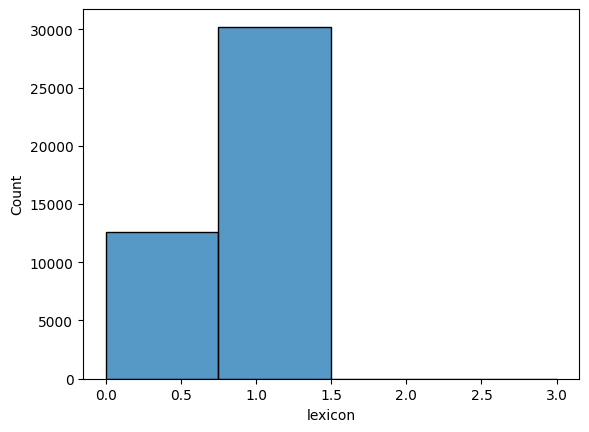

In [50]:
sns.histplot(data=full_train_players, x='lexicon', bins=full_train_players.lexicon.nunique())

<AxesSubplot:xlabel='rating', ylabel='lexicon'>

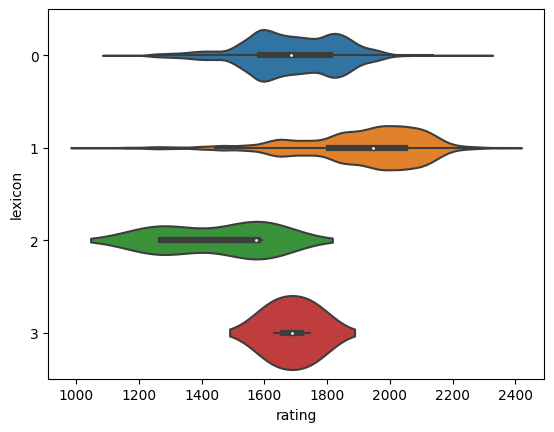

In [51]:
sns.violinplot(data=full_train_players , x='rating', y=full_train_players['lexicon'].astype('category'))

<AxesSubplot:xlabel='time_control', ylabel='Count'>

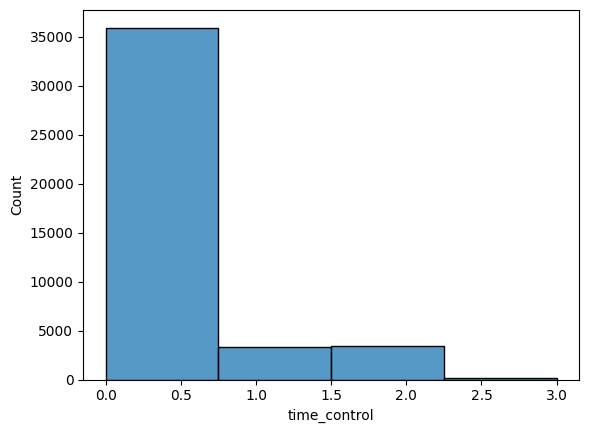

In [52]:
sns.histplot(data=full_train_players, x='time_control', bins=full_train_players.time_control.nunique())

<AxesSubplot:xlabel='rating', ylabel='time_control'>

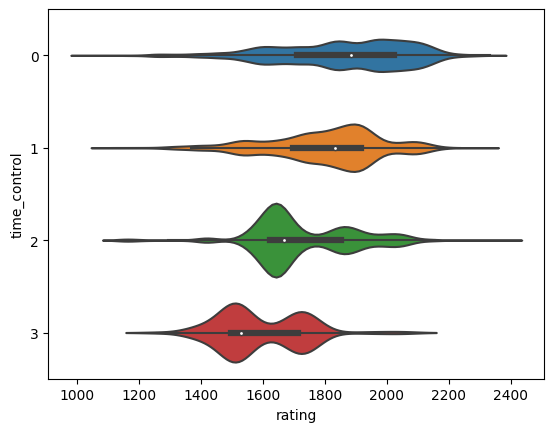

In [53]:
sns.violinplot(data=full_train_players , x='rating', y=full_train_players['time_control'].astype('category'))

<AxesSubplot:xlabel='game_end_reason', ylabel='Count'>

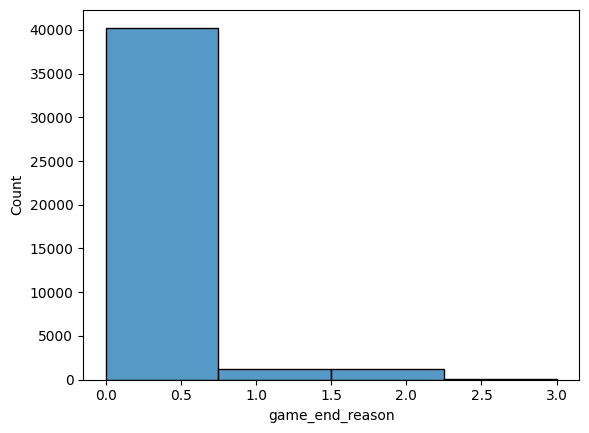

In [54]:
sns.histplot(data=full_train_players, x='game_end_reason', bins=full_train_players.game_end_reason.nunique())

<AxesSubplot:xlabel='rating', ylabel='game_end_reason'>

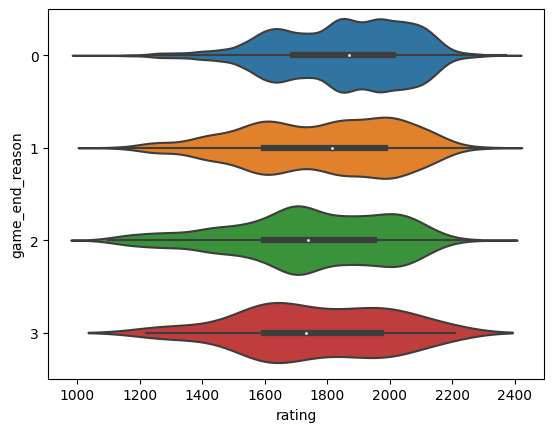

In [55]:
sns.violinplot(data=full_train_players , x='rating', y=full_train_players['game_end_reason'].astype('category'))

## Dropping categoricals not present in test

In [56]:
print(full_train_players.lexicon.value_counts())
print(full_test_players.lexicon.value_counts())

1    30226
0    12591
2        7
3        2
Name: lexicon, dtype: int64
1    14114
0     7907
2      342
Name: lexicon, dtype: int64


In [57]:
full_train_players = full_train_players[full_train_players.lexicon != 3]

In [58]:
print(full_train_players.time_control.value_counts(normalize=True))
print(full_test_players.time_control.value_counts(normalize=True))

0    0.838922
2    0.078904
1    0.078811
3    0.003363
Name: time_control, dtype: float64
0    0.752672
1    0.145150
3    0.054063
2    0.048115
Name: time_control, dtype: float64


In [59]:
print(full_train_players.game_end_reason.value_counts(normalize=True))
print(full_test_players.game_end_reason.value_counts(normalize=True))

0    0.940244
1    0.028605
2    0.028325
3    0.002826
Name: game_end_reason, dtype: float64
0    0.907436
1    0.047489
2    0.042615
3    0.002459
Name: game_end_reason, dtype: float64


## Dropping abandoned games

In [62]:
len(full_train_players)
full_train_players = full_train_players[(full_train_players.turn_type_Pass) < (full_train_players.turn_type_Play)*2]
len(full_train_players)

42783

## Creating log data

In [60]:
full_train_players.columns

Index(['game_id', 'nickname', 'score', 'rating', 'move_len_avg',
       'move_len_med', 'game_turns', 'extreme_plays', 'ppl_max', 'ppl_avg',
       'turn_type_Challenge', 'turn_type_End', 'turn_type_Exchange',
       'turn_type_Mistake', 'turn_type_Pass', 'turn_type_Play',
       'turn_type_Six-Zero Rule', 'turn_type_Timeout', 'move_len_0',
       'move_len_1', 'move_len_2', 'move_len_3', 'move_len_4', 'move_len_5',
       'move_len_6', 'move_len_7', 'move_len_8', 'move_len_9', 'move_len_10',
       'move_len_11', 'move_len_13', 'opponent', 'bot_type',
       'move_len_avg_by_oponent', 'move_len_med_by_oponent',
       'game_turns_by_oponent', 'extreme_plays_by_oponent',
       'ppl_max_by_oponent', 'ppl_avg_by_oponent',
       'turn_type_Challenge_by_oponent', 'turn_type_End_by_oponent',
       'turn_type_Exchange_by_oponent', 'turn_type_Pass_by_oponent',
       'turn_type_Play_by_oponent', 'move_len_0_by_oponent',
       'move_len_1_by_oponent', 'move_len_2_by_oponent',
       'move_

In [61]:
full_train_temp = full_train_players[['game_id','nickname','rating']]

In [62]:
full_train_players_rating = full_train_players['rating']

In [63]:
len(full_train_players)

42824

In [64]:
full_train_players_log = np.log2(full_train_players)
print(len(full_train_players_log))
full_train_players_log = full_train_players_log.drop(['game_id', 'nickname'], axis=1)
print(len(full_train_players_log))
full_train_players_log[['game_id', 'nickname']] = full_train_players[['game_id', 'nickname']]
print(len(full_train_players_log))

42824
42824
42824


C:\Users\marci\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
C:\Users\marci\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


In [65]:
full_test_players_log = np.log2(full_test_players)
print(len(full_test_players_log))
full_test_players_log = full_test_players_log.drop(['game_id', 'nickname'], axis=1)
print(len(full_test_players_log))
full_test_players_log[['game_id', 'nickname']] = full_test_players[['game_id', 'nickname']]
print(len(full_test_players_log))

22363
22363
22363


C:\Users\marci\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
C:\Users\marci\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


In [66]:
full_train_players_log.sample(2)

,score,rating,move_len_avg,move_len_med,game_turns,extreme_plays,ppl_max,ppl_avg,turn_type_Challenge,turn_type_End,...,time_control,game_end_reason,lexicon,rating_mode,minutes_since_last,score_previous,score_previous_2,score_delta,game_id,nickname
17227,8.434628,10.848623,2.405992,2.321928,4.321928,2.321928,3.321928,2.622735,-inf,0.0,...,-inf,-inf,-inf,0.0,2.364572,8.758223,8.495855,6.169925,12366,774
81343,8.523562,10.619303,2.196397,2.000000,4.700440,3.169925,3.421464,2.689255,-inf,0.0,...,-inf,-inf,-inf,0.0,2.715893,8.463524,8.592457,NaN,58756,742


In [67]:
full_train_players_log.replace([np.inf, -np.inf], np.nan, inplace=True)
full_train_players_log = full_train_players_log.dropna(how='any', axis=1)
full_train_players_log

,rating,game_turns,opponent,bot_type,move_len_avg_by_oponent,move_len_med_by_oponent,game_turns_by_oponent,extreme_plays_by_oponent,ppl_max_by_oponent,ppl_avg_by_oponent,turn_type_Play_by_oponent,init_time_secs,game_dur_secs,weekday,game_id,nickname
2,10.822571,4.700440,10.063395,0.000000,2.169925,2.000000,4.643856,2.584963,3.523562,2.612558,3.584963,9.813781,8.942515,2.807355,3,24
4,10.524542,4.807355,10.063395,0.000000,2.341037,2.321928,4.857981,2.807355,3.847997,2.690736,3.906891,11.813781,8.451211,0.000000,4,389
8,10.986553,4.523562,7.339850,1.000000,2.321928,2.000000,4.584963,2.321928,3.426265,2.873894,3.459432,9.813781,8.734710,2.807355,6,728
11,11.013323,4.459432,10.317413,1.584963,2.423211,2.321928,4.523562,2.807355,3.584963,3.125030,3.459432,9.813781,8.839204,1.000000,8,46
12,10.680360,4.807355,10.063395,0.000000,2.099536,2.000000,4.754888,2.584963,4.426265,3.019466,3.807355,10.228819,9.147205,2.321928,9,698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100808,11.016808,4.523562,7.339850,1.000000,2.321928,2.000000,4.459432,2.321928,3.662965,3.033757,3.459432,10.228819,9.717676,2.321928,72766,21
100810,10.446049,4.906891,10.063395,0.000000,2.189825,2.000000,4.954196,3.000000,3.321928,2.515137,4.000000,11.813781,11.841171,0.000000,72767,381
100813,10.379378,4.906891,10.317413,1.584963,2.303781,2.169925,4.954196,3.000000,3.727920,2.851779,4.000000,11.813781,11.838416,2.807355,72770,784
100817,10.413628,4.857981,10.063395,0.000000,2.192645,2.169925,4.807355,3.000000,4.169925,2.940231,3.807355,9.813781,9.411511,1.584963,72772,750


In [68]:
full_test_players_log.replace([np.inf, -np.inf], np.nan, inplace=True)
full_test_players_log = full_test_players_log.dropna(how='any', axis=1)
full_test_players_log

,game_turns,opponent,bot_type,move_len_avg_by_oponent,move_len_med_by_oponent,game_turns_by_oponent,extreme_plays_by_oponent,ppl_max_by_oponent,ppl_avg_by_oponent,turn_type_Play_by_oponent,init_time_secs,game_dur_secs,weekday,game_id,nickname
0,4.643856,10.063395,0.000000,2.392317,2.321928,4.584963,2.000000,3.602036,2.577117,3.584963,11.813781,8.507795,1.584963,2,783
3,4.643856,7.339850,1.000000,2.080920,2.000000,4.700440,3.000000,3.146841,2.597677,3.700440,10.299208,8.588715,2.321928,7,561
5,4.754888,7.339850,1.000000,1.971986,2.000000,4.807355,2.584963,3.440573,2.683100,3.700440,10.228819,8.968667,0.000000,11,1016
7,4.807355,7.339850,1.000000,2.075288,2.000000,4.754888,3.000000,3.618910,2.761524,3.807355,9.813781,8.194757,1.584963,14,925
8,4.392317,10.317413,1.584963,2.373458,2.321928,4.459432,2.584963,3.700440,2.973766,3.459432,10.228819,7.665336,1.000000,27,485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44717,4.321928,7.339850,1.000000,2.347923,2.321928,4.392317,2.584963,3.523562,2.800155,3.459432,10.228819,7.066089,2.807355,72760,1046
44718,5.321928,10.063395,0.000000,2.058894,2.000000,5.357552,3.321928,4.000000,2.674430,4.169925,10.228819,8.049849,2.807355,72761,868
44721,4.754888,10.063395,0.000000,2.237039,2.321928,4.807355,3.321928,3.104337,2.123889,3.807355,11.813781,8.592457,1.584963,72762,321
44723,4.459432,10.317413,1.584963,2.423211,2.584963,4.392317,3.169925,4.700440,3.323754,3.459432,11.813781,11.073472,2.584963,72768,1071


## Creating squared data

In [69]:
full_train_players_sqrd = np.log2(full_train_players)
print(len(full_train_players_sqrd))
full_train_players_sqrd = full_train_players_sqrd.drop(['game_id', 'nickname'], axis=1)
print(len(full_train_players_sqrd))
full_train_players_sqrd[['game_id', 'nickname']] = full_train_players[['game_id', 'nickname']]
print(len(full_train_players_sqrd))

42824
42824
42824


C:\Users\marci\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
C:\Users\marci\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


In [70]:
full_test_players_sqrd = np.log2(full_test_players)
print(len(full_test_players_sqrd))
full_test_players_sqrd = full_test_players_sqrd.drop(['game_id', 'nickname'], axis=1)
print(len(full_test_players_sqrd))
full_test_players_sqrd[['game_id', 'nickname']] = full_test_players[['game_id', 'nickname']]
print(len(full_test_players_sqrd))

22363
22363
22363


C:\Users\marci\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
C:\Users\marci\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


In [71]:
full_train_players_sqrd.replace([np.inf, -np.inf], np.nan, inplace=True)
full_train_players_sqrd = full_train_players_sqrd.dropna(how='any', axis=1)
full_train_players_sqrd

,rating,game_turns,opponent,bot_type,move_len_avg_by_oponent,move_len_med_by_oponent,game_turns_by_oponent,extreme_plays_by_oponent,ppl_max_by_oponent,ppl_avg_by_oponent,turn_type_Play_by_oponent,init_time_secs,game_dur_secs,weekday,game_id,nickname
2,10.822571,4.700440,10.063395,0.000000,2.169925,2.000000,4.643856,2.584963,3.523562,2.612558,3.584963,9.813781,8.942515,2.807355,3,24
4,10.524542,4.807355,10.063395,0.000000,2.341037,2.321928,4.857981,2.807355,3.847997,2.690736,3.906891,11.813781,8.451211,0.000000,4,389
8,10.986553,4.523562,7.339850,1.000000,2.321928,2.000000,4.584963,2.321928,3.426265,2.873894,3.459432,9.813781,8.734710,2.807355,6,728
11,11.013323,4.459432,10.317413,1.584963,2.423211,2.321928,4.523562,2.807355,3.584963,3.125030,3.459432,9.813781,8.839204,1.000000,8,46
12,10.680360,4.807355,10.063395,0.000000,2.099536,2.000000,4.754888,2.584963,4.426265,3.019466,3.807355,10.228819,9.147205,2.321928,9,698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100808,11.016808,4.523562,7.339850,1.000000,2.321928,2.000000,4.459432,2.321928,3.662965,3.033757,3.459432,10.228819,9.717676,2.321928,72766,21
100810,10.446049,4.906891,10.063395,0.000000,2.189825,2.000000,4.954196,3.000000,3.321928,2.515137,4.000000,11.813781,11.841171,0.000000,72767,381
100813,10.379378,4.906891,10.317413,1.584963,2.303781,2.169925,4.954196,3.000000,3.727920,2.851779,4.000000,11.813781,11.838416,2.807355,72770,784
100817,10.413628,4.857981,10.063395,0.000000,2.192645,2.169925,4.807355,3.000000,4.169925,2.940231,3.807355,9.813781,9.411511,1.584963,72772,750


In [72]:
full_test_players_sqrd.replace([np.inf, -np.inf], np.nan, inplace=True)
full_test_players_sqrd = full_test_players_sqrd.dropna(how='any', axis=1)
full_test_players_sqrd

,game_turns,opponent,bot_type,move_len_avg_by_oponent,move_len_med_by_oponent,game_turns_by_oponent,extreme_plays_by_oponent,ppl_max_by_oponent,ppl_avg_by_oponent,turn_type_Play_by_oponent,init_time_secs,game_dur_secs,weekday,game_id,nickname
0,4.643856,10.063395,0.000000,2.392317,2.321928,4.584963,2.000000,3.602036,2.577117,3.584963,11.813781,8.507795,1.584963,2,783
3,4.643856,7.339850,1.000000,2.080920,2.000000,4.700440,3.000000,3.146841,2.597677,3.700440,10.299208,8.588715,2.321928,7,561
5,4.754888,7.339850,1.000000,1.971986,2.000000,4.807355,2.584963,3.440573,2.683100,3.700440,10.228819,8.968667,0.000000,11,1016
7,4.807355,7.339850,1.000000,2.075288,2.000000,4.754888,3.000000,3.618910,2.761524,3.807355,9.813781,8.194757,1.584963,14,925
8,4.392317,10.317413,1.584963,2.373458,2.321928,4.459432,2.584963,3.700440,2.973766,3.459432,10.228819,7.665336,1.000000,27,485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44717,4.321928,7.339850,1.000000,2.347923,2.321928,4.392317,2.584963,3.523562,2.800155,3.459432,10.228819,7.066089,2.807355,72760,1046
44718,5.321928,10.063395,0.000000,2.058894,2.000000,5.357552,3.321928,4.000000,2.674430,4.169925,10.228819,8.049849,2.807355,72761,868
44721,4.754888,10.063395,0.000000,2.237039,2.321928,4.807355,3.321928,3.104337,2.123889,3.807355,11.813781,8.592457,1.584963,72762,321
44723,4.459432,10.317413,1.584963,2.423211,2.584963,4.392317,3.169925,4.700440,3.323754,3.459432,11.813781,11.073472,2.584963,72768,1071


## Combining log and squared

In [73]:
full_train_players = full_train_players.merge(full_train_players_log, on=['game_id', 'nickname'])
full_train_players = full_train_players.merge(full_train_players_sqrd, on=['game_id', 'nickname'])

In [74]:
full_test_players = full_test_players.merge(full_test_players_log, on=['game_id', 'nickname'])
full_test_players = full_test_players.merge(full_test_players_sqrd, on=['game_id', 'nickname'])

In [75]:
train_cols = set(full_train_players.columns)
test_cols = set(full_test_players.columns)
all_cols = train_cols.intersection(test_cols)
print(len(all_cols))

99


In [76]:
full_train_players = full_train_players[all_cols]
full_test_players = full_test_players[all_cols]
print(len(full_test_players.columns))
print(len(full_train_players.columns))

99
99


C:\Users\marci\AppData\Local\Temp\ipykernel_5736\2840600631.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  full_train_players = full_train_players[all_cols]
C:\Users\marci\AppData\Local\Temp\ipykernel_5736\2840600631.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  full_test_players = full_test_players[all_cols]


In [77]:
full_train_players = full_train_temp.merge(full_train_players, on=['game_id', 'nickname'])
#full_test_players['rating'] = full_test_players_rating

In [78]:
full_train_players

,game_id,nickname,rating,ppl_max,turn_type_Exchange_by_oponent,turn_type_Mistake,minutes_since_last,game_turns_by_oponent,move_len_9,move_len_14_by_oponent,...,ppl_avg,extreme_plays_by_oponent,ppl_max_by_oponent_y,move_len_13_by_oponent,ppl_avg_by_oponent_x,init_time_secs_x,bot_type,move_len_0_by_oponent,move_len_10,move_len_avg_by_oponent_x
0,3,24,1811,18.000000,1,0,644.85,4.643856,0,0,...,8.212637,2.584963,3.523562,0,6.115873,900,0.000000,0,0,4.500000
1,4,389,1473,8.000000,0,0,224.32,4.857981,0,0,...,3.381944,2.807355,3.847997,0,6.456429,3600,0.000000,0,0,5.066667
2,6,728,2029,14.800000,1,0,213.92,4.584963,0,0,...,6.718056,2.321928,3.426265,0,7.330411,900,1.000000,0,0,5.000000
3,8,46,2067,13.000000,1,0,20.03,4.523562,0,0,...,7.869697,2.807355,3.584963,0,8.724242,900,1.584963,0,0,5.363636
4,9,698,1641,12.571429,0,0,19.85,4.754888,0,0,...,6.343956,2.584963,4.426265,0,8.108673,1200,0.000000,0,0,4.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42819,72766,21,2072,16.375000,0,0,11.82,4.459432,0,0,...,7.537554,2.321928,3.662965,0,8.189394,1200,1.000000,0,0,5.000000
42820,72767,381,1395,18.000000,0,0,290.45,4.954196,0,0,...,6.839524,3.000000,3.321928,0,5.716518,3600,0.000000,0,0,4.562500
42821,72770,784,1332,6.000000,0,0,11.70,4.954196,0,0,...,2.538889,3.000000,3.727920,0,7.218899,3600,1.584963,0,0,4.937500
42822,72772,750,1364,21.000000,0,0,1150.25,4.807355,0,0,...,7.585317,3.000000,4.169925,0,7.675340,900,0.000000,0,0,4.571429


## Checking distributions and suspicious values

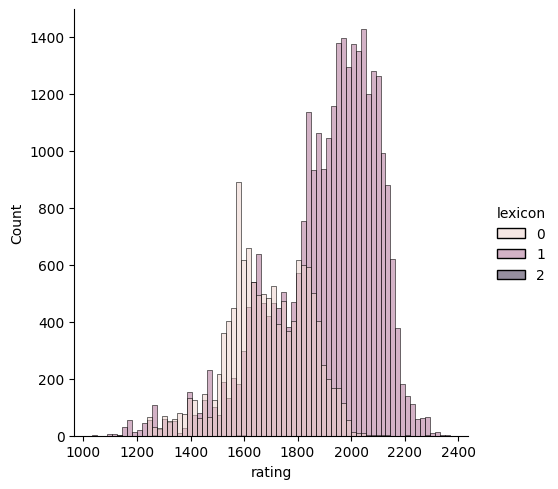

In [79]:
sns.displot(data=full_train_players, x="rating", kind='hist', hue='lexicon')

## Checking drops

In [80]:
full_train_players[full_train_players.rating > 2400]

,game_id,nickname,rating,ppl_max,turn_type_Exchange_by_oponent,turn_type_Mistake,minutes_since_last,game_turns_by_oponent,move_len_9,move_len_14_by_oponent,...,ppl_avg,extreme_plays_by_oponent,ppl_max_by_oponent_y,move_len_13_by_oponent,ppl_avg_by_oponent_x,init_time_secs_x,bot_type,move_len_0_by_oponent,move_len_10,move_len_avg_by_oponent_x


In [81]:
full_train_players[(full_train_players.turn_type_Pass) > (full_train_players.turn_type_Play)*2]

,game_id,nickname,rating,ppl_max,turn_type_Exchange_by_oponent,turn_type_Mistake,minutes_since_last,game_turns_by_oponent,move_len_9,move_len_14_by_oponent,...,ppl_avg,extreme_plays_by_oponent,ppl_max_by_oponent_y,move_len_13_by_oponent,ppl_avg_by_oponent_x,init_time_secs_x,bot_type,move_len_0_by_oponent,move_len_10,move_len_avg_by_oponent_x
946,1635,1172,2003,12.000000,2,0,508.92,5.459432,0,0,...,8.221939,3.807355,4.700440,0,6.601250,900,0.000000,0,0,4.350000
2126,3623,954,1523,2.285714,0,0,11762.37,5.554589,0,0,...,2.285714,4.000000,3.584963,0,6.079365,1200,0.000000,0,0,4.458333
3519,5980,389,1508,NaN,1,0,3981.87,4.584963,0,0,...,NaN,1.584963,4.273018,0,7.759740,1080,0.000000,0,0,4.545455
3716,6301,400,1452,4.000000,0,0,4.32,5.523562,0,0,...,3.000000,3.807355,4.000000,0,7.536491,600,1.000000,0,0,4.434783
5509,9299,775,1965,10.666667,0,0,9.37,5.321928,0,0,...,5.616667,3.459432,3.841302,0,8.774881,720,1.584963,0,0,4.450000
6167,10459,910,1698,8.750000,0,0,15.10,5.321928,0,0,...,4.970833,3.584963,3.550197,0,6.604167,1800,0.000000,0,0,4.500000
9968,16882,945,1997,NaN,0,0,0.00,5.491853,0,0,...,NaN,3.584963,4.087463,0,7.038768,1200,0.000000,0,0,4.739130
13401,22761,965,1346,5.000000,0,0,2.42,5.285402,0,0,...,3.900000,3.906891,4.087463,0,7.215595,900,1.584963,0,0,5.250000
13825,23457,1420,1958,NaN,1,0,14.00,5.554589,0,0,...,NaN,3.700440,3.550197,0,6.769048,3300,0.000000,0,0,4.652174
14889,25259,1257,1877,18.000000,0,0,3.58,5.321928,0,0,...,8.191667,3.700440,3.624491,0,6.557738,1200,1.000000,0,0,5.150000


In [82]:
print(len(full_train_players.columns))
ratings = full_train_players.pop('rating')
print(len(full_train_players.columns))
full_train_players['rating'] = ratings
print(len(full_train_players.columns))

100
99
100


## Plotting relations to rating

In [ ]:
for x in full_train_players.columns:
    
    fig, ax = plt.subplots(1,2)
    #plt.figure(figsize=(3, 5))
    fig.set_size_inches(12,3)
    sns.regplot(data=full_train_players, x='rating', y=x, ax=ax[0])
    sns.regplot(data=full_train_players_log, x='rating', y=x, ax=ax[1])
    plt.show()

## Final features

In [ ]:
features_train = [
    'game_id', 'nickname', 'score', 'rating', 'move_len_avg','move_len_med', 'game_turns',
    'extreme_plays', 'ppl_max','ppl_avg', 'move_len_4', 'move_len_5', 'move_len_6','move_len_7',
    'move_len_8', 'bot_type','move_len_avg_by_oponent', 'move_len_med_by_oponent', 'game_turns_by_oponent',
    'extreme_plays_by_oponent', 'ppl_avg_by_oponent', 'turn_type_Play_by_oponent', 'move_len_2_by_oponent',
    'move_len_3_by_oponent', 'move_len_4_by_oponent', 'move_len_5_by_oponent', 'winner', 'time_control',
    'lexicon', 'rating_mode', 'score_previous', 'score_previous_2', 'score_delta'
    ]

features_test = [
    'game_id', 'nickname', 'score', 'move_len_avg','move_len_med', 'game_turns',
    'extreme_plays', 'ppl_max','ppl_avg', 'move_len_4', 'move_len_5', 'move_len_6','move_len_7',
    'move_len_8', 'bot_type','move_len_avg_by_oponent', 'move_len_med_by_oponent', 'game_turns_by_oponent',
    'extreme_plays_by_oponent', 'ppl_avg_by_oponent', 'turn_type_Play_by_oponent', 'move_len_2_by_oponent',
    'move_len_3_by_oponent', 'move_len_4_by_oponent', 'move_len_5_by_oponent', 'winner', 'time_control',
    'lexicon', 'rating_mode', 'score_previous', 'score_previous_2', 'score_delta'
    ]

In [ ]:
full_train_players = full_train_players[features_train]
full_test_players = full_test_players[features_test]

## Sweetviz

In [112]:
import sweetviz

In [114]:
sv_report_train = sweetviz.analyze([full_train_players, "Train"],target_feat='rating')

                                             |                                             | [  0%]   00:00 ->…

In [115]:
sv_report_train.show_html('sv_report_train.html')

Report sv_report_train.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Training

In [83]:
# Using PyCaret to find best model

import pycaret
from pycaret.regression import *

In [84]:
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("scrabble")

<Experiment: artifact_location='mlflow-artifacts:/745893657283578021', creation_time=1669652193129, experiment_id='745893657283578021', last_update_time=1669652193129, lifecycle_stage='active', name='scrabble', tags={}>

In [84]:
# define columns for ml

#categorical_features = ['time_control_name','game_end_reason', 'lexicon']

#high_cardinality_features = ['nickname', 'opponent'] # outdated

ignore_features = ['nickname', 'game_id', 'rating_x', 'rating_y']

In [85]:
s = setup(full_train_players,
          target='rating',
          normalize=False,
          train_size=0.7,
          #normalize_method='minmax',
          numeric_imputation=0,
          ignore_features=ignore_features,
          #log_experiment = True,
          #experiment_name = 'scrabble',
          #categorical_features=categorical_features,
          #polynomial_features=True,
          feature_selection=True,
          n_features_to_select=15,
          #remove_multicollinearity=True
         )

,Description,Value
0,Session id,2569
1,Target,rating
2,Target type,Regression
3,Data shape,"(42824, 16)"
4,Train data shape,"(29976, 16)"
5,Test data shape,"(12848, 16)"
6,Ignore features,4
7,Numeric features,97
8,Rows with missing values,0.0%
9,Preprocess,True


In [86]:
top5 = compare_models(sort = 'RMSE', exclude = ['huber', 'lar'], round = 4, n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,78.2807,11477.8988,107.1204,0.7420,0.0613,0.0441,1.9140
et,Extra Trees Regressor,76.0430,11480.6266,107.1207,0.7419,0.0610,0.0427,0.9100
lightgbm,Light Gradient Boosting Machine,81.4170,12303.2260,110.9035,0.7234,0.0634,0.0459,0.0880
rf,Random Forest Regressor,80.5972,12631.1622,112.3630,0.7161,0.0642,0.0454,1.8390
xgboost,Extreme Gradient Boosting,82.0763,12688.8190,112.6343,0.7147,0.0646,0.0462,0.4190
gbr,Gradient Boosting Regressor,91.7829,14942.0469,122.2170,0.6642,0.0701,0.0520,0.6340
lr,Linear Regression,104.8639,19905.5823,141.0601,0.5526,0.0810,0.0596,0.9800
ridge,Ridge Regression,104.8646,19905.5830,141.0601,0.5526,0.0810,0.0596,0.0500
br,Bayesian Ridge,104.8672,19905.5968,141.0602,0.5526,0.0810,0.0596,0.0510
lasso,Lasso Regression,105.1207,19944.4952,141.1982,0.5517,0.0811,0.0598,0.3320


In [87]:
best_model = create_model(top5[0], fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,79.5695,12106.0698,110.0276,0.7198,0.0629,0.0448
1,76.2223,10810.8176,103.9751,0.7519,0.0597,0.0430
2,78.1670,11465.4168,107.0767,0.7430,0.0612,0.0439
3,78.1863,11179.8201,105.7347,0.7484,0.0603,0.0440
4,79.8661,11705.7404,108.1931,0.7411,0.0613,0.0448
5,78.1836,11473.7545,107.1156,0.7475,0.0613,0.0441
6,78.5578,11611.5798,107.7570,0.7398,0.0614,0.0441
7,78.8275,11910.1714,109.1337,0.7311,0.0629,0.0447
8,76.8612,10986.1485,104.8148,0.7531,0.0604,0.0433


In [ ]:
et_params = {'n_estimators' : [70, 80, 100, 120,140],
             'max_features' : np.arange(11, 32, 2),
             'min_samples_leaf' : np.arange(2, 11, 2)
            }

In [ ]:
catboost_params = {'learning_rate' : np.arange(0.01, 0.2, 0.01),
                   'od_type' : "Iter",
                  }

In [ ]:
best_model_tuned = tune_model(best_model,
                              optimize='RMSE',
                              n_iter=10,
                              fold=10,
                              early_stopping='asha',
                              choose_better=True,
                              tuner_verbose = 10,
                              search_library='scikit-learn',
                              search_algorithm='grid',
                              custom_grid = et_params
                             )

## Analyze

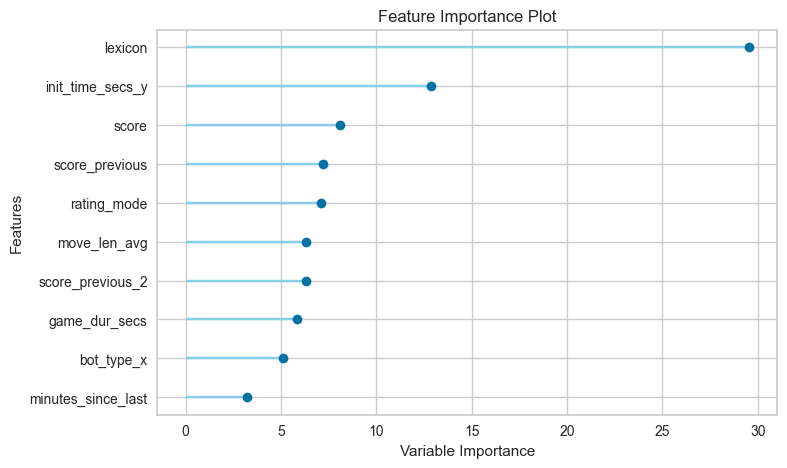

In [88]:
plot_model(best_model, plot='feature')

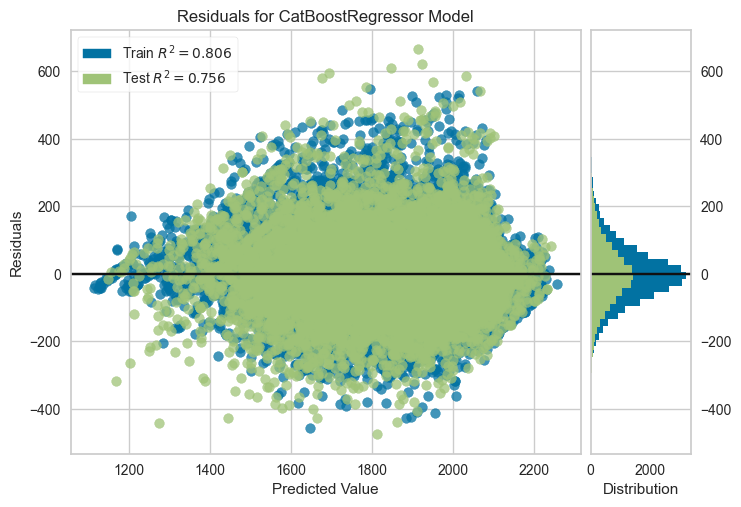

In [89]:
plot_model(best_model, plot='residuals')

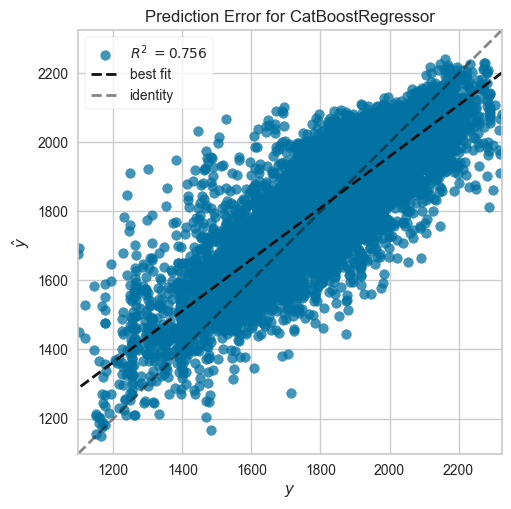

In [90]:
plot_model(best_model, plot='error')

In [ ]:
plot_model(best_model, plot='rfe')

## Tune

In [ ]:
best_model_boosted = ensemble_model(best_model, method='Boosting', choose_better=True)

In [ ]:
best_model_bagged = ensemble_model(best_model_boosted, method='Bagging', choose_better=True)

In [ ]:
best_model_blend = blend_models(top5)

## Saving model

In [91]:
import time

now = time.strftime('%Y%m%d_%H%M%S')

rmse = round(pull().RMSE[0], 0).astype(int).astype(str)

stamp = now+'_'+rmse
stamp

'20221209_010520_110'

In [92]:
predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,76.5500,10806.7832,103.9557,0.7561,0.0593,0.0430


,minutes_since_last,move_len_avg_by_oponent,opponent_y,init_time_secs_y,game_dur_secs,time,bot_type_x,ppl_avg_by_oponent,lexicon,score_previous,rating_mode,move_len_avg,score,max_otime_mins,score_previous_2,rating,prediction_label
29976,54.680000,2.523562,10.317412,10.228819,9.461479,19.0,3.0,2.919992,0.0,411.0,0.0,4.363636,393.0,0.0,417.0,1615,1771.900315
29977,162.350006,2.276840,7.339850,10.228819,8.906891,16.0,2.0,2.640428,0.0,300.0,1.0,3.846154,367.0,1.0,371.0,1704,1629.562691
29978,17.580000,2.129283,7.339850,10.228819,9.457381,16.0,2.0,2.523226,1.0,424.0,1.0,3.800000,421.0,1.0,301.0,1920,1927.724915
29979,1.880000,2.297681,10.063396,8.228819,7.033423,1.0,1.0,2.781672,1.0,267.0,1.0,4.333333,320.0,1.0,368.0,1794,1636.211035
29980,5.870000,2.066089,10.063396,10.228819,8.618385,4.0,1.0,2.790620,0.0,323.0,1.0,3.214286,285.0,1.0,292.0,1482,1421.184400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42819,6.570000,2.087463,10.063396,10.228819,9.092757,12.0,1.0,2.488605,1.0,295.0,1.0,3.437500,356.0,1.0,375.0,1940,1838.500227
42820,1323.520020,1.917538,10.063396,11.813781,10.239598,11.0,1.0,2.340509,1.0,400.0,1.0,4.285714,395.0,1.0,367.0,1998,2017.974013
42821,7.300000,1.947533,10.063396,9.813781,9.162392,16.0,1.0,2.705752,1.0,369.0,1.0,3.866667,369.0,1.0,333.0,2095,1878.019391
42822,0.330000,1.817136,10.063396,10.228819,8.405142,12.0,1.0,2.340585,1.0,509.0,1.0,2.550000,281.0,1.0,359.0,1333,1680.789052


In [93]:
best_model_final = finalize_model(best_model)

In [94]:
save_model(best_model_final, 'models/model_'+stamp)

Transformation Pipeline and Model Successfully Saved


(<catboost.core.CatBoostRegressor at 0x286159115b0>,
 'models/model_20221209_010520_110.pkl')

In [95]:
final_labels = predict_model(best_model_final, data=full_test_players)
final_labels.head()

,minutes_since_last,move_len_avg_by_oponent,opponent_y,init_time_secs_y,game_dur_secs,time,bot_type_x,ppl_avg_by_oponent,lexicon,score_previous,rating_mode,move_len_avg,score,max_otime_mins,score_previous_2,prediction_label
0,5523.020020,2.392318,10.063396,11.813781,8.507794,19.0,1.0,2.577117,1.0,377.0,1.0,4.250000,488.0,1.0,377.0,1998.527849
1,8.450000,2.080920,7.339850,10.299208,8.588715,3.0,2.0,2.597677,1.0,377.0,1.0,3.916667,379.0,1.0,377.0,1992.112358
2,10.500000,1.971986,7.339850,10.228819,8.968667,1.0,2.0,2.683100,0.0,334.0,0.0,4.307693,462.0,1.0,377.0,1684.879133
3,112.970001,2.075288,7.339850,9.813781,8.194757,14.0,2.0,2.761524,1.0,401.0,1.0,4.071429,359.0,1.0,334.0,1978.664660
4,4.300000,2.373458,10.317412,10.228819,7.665336,9.0,3.0,2.973766,1.0,401.0,1.0,4.454545,456.0,1.0,334.0,2050.400118


# Final labels

In [96]:
final_labels

,minutes_since_last,move_len_avg_by_oponent,opponent_y,init_time_secs_y,game_dur_secs,time,bot_type_x,ppl_avg_by_oponent,lexicon,score_previous,rating_mode,move_len_avg,score,max_otime_mins,score_previous_2,prediction_label
0,5523.020020,2.392318,10.063396,11.813781,8.507794,19.0,1.0,2.577117,1.0,377.0,1.0,4.250000,488.0,1.0,377.0,1998.527849
1,8.450000,2.080920,7.339850,10.299208,8.588715,3.0,2.0,2.597677,1.0,377.0,1.0,3.916667,379.0,1.0,377.0,1992.112358
2,10.500000,1.971986,7.339850,10.228819,8.968667,1.0,2.0,2.683100,0.0,334.0,0.0,4.307693,462.0,1.0,377.0,1684.879133
3,112.970001,2.075288,7.339850,9.813781,8.194757,14.0,2.0,2.761524,1.0,401.0,1.0,4.071429,359.0,1.0,334.0,1978.664660
4,4.300000,2.373458,10.317412,10.228819,7.665336,9.0,3.0,2.973766,1.0,401.0,1.0,4.454545,456.0,1.0,334.0,2050.400118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22358,3.230000,2.347923,7.339850,10.228819,7.066089,5.0,2.0,2.800155,1.0,413.0,1.0,5.000000,494.0,3.0,432.0,1995.307789
22359,6.950000,2.058894,10.063396,10.228819,8.049849,12.0,1.0,2.674430,1.0,280.0,1.0,2.923077,232.0,1.0,243.0,1601.906274
22360,2181.199951,2.237039,10.063396,11.813781,8.592457,11.0,1.0,2.123889,0.0,346.0,0.0,3.538461,367.0,1.0,365.0,1556.954921
22361,1377.449951,2.423211,10.317412,11.813781,11.073472,7.0,3.0,3.323754,1.0,409.0,1.0,4.818182,357.0,1.0,353.0,2018.317969


In [97]:
# Reversing names

inv_players = {v: k for k, v in players_dict.items()}

In [98]:
submission = pd.DataFrame()
submission['game_id'] = full_test_players['game_id']
submission = submission.reset_index(drop=True)
submission['rating'] = final_labels['prediction_label'].astype('int')
#submission['nickname'] = full_test_players['nickname']
display(submission)
#submission['nickname'] = submission['nickname'].replace(inv_players).astype('string')
#submission = submission[~submission['nickname'].isin(bots)]
#submission = submission.reset_index(drop=True)
#submission = submission.drop('nickname', axis=1)
#display(submission)

,game_id,rating
0,2,1998
1,7,1992
2,11,1684
3,14,1978
4,27,2050
...,...,...
22358,72760,1995
22359,72761,1601
22360,72762,1556
22361,72768,2018


In [99]:
print("Expected test lenght: {}".format(44726/2))

Expected test lenght: 22363.0


In [100]:
submission.to_csv('predictions/submission_'+stamp+'.csv', index=False)

In [101]:
stamp

'20221209_010520_110'